In [1]:
import pandas as pd
import numpy as np

In [2]:
from src.tools.data import Data

In [3]:
from torch.utils.data import DataLoader
from tqdm import tqdm

In [4]:
data = DataLoader(Data(val=False))

In [5]:
X,y = next(iter(data))

In [6]:
import matplotlib.pyplot as plt


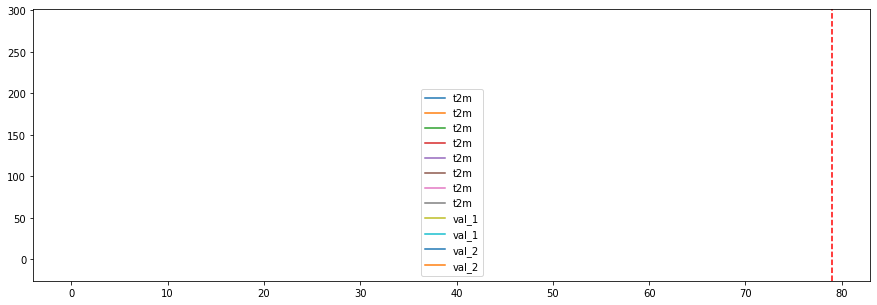

In [7]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(X[:, 1].shape[0]), X[:, 0], label='t2m')
plt.plot(np.arange(y[:, 1].shape[0]), y[:, 0], label='val_1')
plt.plot(np.arange(y[:, 1].shape[0]), y[:, 1], label='val_2')
plt.axvline(79, color='r', linestyle='--')
plt.legend()
plt.show()


In [8]:
import torch
import torch.nn as nn

t = torch.linspace(0,1,81)

In [9]:
X.shape

torch.Size([1, 80, 8])

In [7]:
from src.torchdiffeq import odeint
from src.tools.model import ODEF

In [11]:
func = ODEF(8, 1, nn.Tanh)

In [12]:
y.shape

torch.Size([1, 81, 2])

In [13]:
pred = odeint(func, y[:, 0, :], X, t, method='euler',
              options={'step_size': 0.0125, 'interp':'linear'})


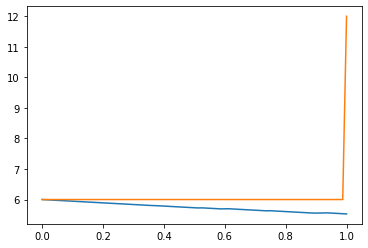

In [14]:
plt.plot(t, pred[:, 0, 0].detach().numpy())
plt.plot(t, y[0, :, 0].detach().numpy())
plt.show()


In [67]:
from tqdm import tqdm

In [50]:
agro = pd.read_parquet('data/agro.parquet').sort_values(by=['ind', 'datetime'])
syn = pd.read_parquet('data/new_syn.parquet').sort_values(by=['ind', 'datetime'])

df = syn.merge(agro, on=['ind', 'datetime']).dropna()
pairs = df[['ind', 'datetime']].drop_duplicates()
filter = [(i, t0) for i, t0, t1 in zip(pairs.ind, pairs.datetime[:-1], pairs.datetime[1:]) if 10 <= (t1-t0).days <= 11]
pairs = df.groupby(['ind', 'datetime']).count().loc[filter]
pairs = pairs[pairs.t2m == 80].reset_index()[['ind', 'datetime']]

pairs = [(i, t0, t1) for i, t0, t1 in zip(pairs.ind, pairs.datetime[:-1], pairs.datetime[1:]) if 10 <= (t1-t0).days <= 11]

df.set_index(['ind', 'datetime'], inplace=True)

In [55]:
i, t1, t2 = pairs[-1]

pd.concat((df.loc[i, t1], df.loc[i, t2].iloc[[0]]), axis=0)


t2m  td2m   ff   R12        phi         air  \
ind   datetime                                                            
66103 2014-06-17 09:00:00  18.6   4.6  2.0   0.0  19.566330  290.634674   
      2014-06-17 09:00:00  17.8   6.5  2.0   0.0  19.560040  290.634674   
      2014-06-17 09:00:00  17.8   6.5  2.0   0.0  19.553705  290.634674   
      2014-06-17 09:00:00  12.0   8.7  1.0   0.0  19.547326  290.634674   
      2014-06-17 09:00:00  10.3   8.2  1.0   0.0  19.540904  290.634674   
...                         ...   ...  ...   ...        ...         ...   
      2014-06-17 09:00:00  14.1  12.9  1.0  12.5  18.964445  290.634674   
      2014-06-17 09:00:00  12.1  10.8  1.0   0.0  18.954888  290.634674   
      2014-06-17 09:00:00  15.4  11.2  2.0   7.5  18.945290  290.634674   
      2014-06-17 09:00:00  18.5  10.4  1.0   0.0  18.935651  290.634674   
      2014-06-27 09:00:00  20.0   8.2  1.0   1.0  18.925970  290.634674   

                                soilw  precip  dec  val_1  val_2  
ind   datetime                                                    
66103 2014-06-17 09:00:00  228.954849   2.221   17   27.0   56.0  
      2014-06-17 09:00:00  228.954849   2.221   17   27.0   56.0  
      2014-06-17 09:00:00  228.954849   2.221   17   27.0   56.0  
      2014-06-17 09:00:00  228.954849   2.221   17   27.0   56.0  
      2014-06-17 09:00:00  228.954849   2.221   17   27.0   56.0  
...                               ...     ...  ...    ...    ...  
      2014-06-17 09:00:00  228.954849   2.221   17   27.0   56.0  
      2014-06-17 09:00:00  228.954849   2.221   17   27.0   56.0  
      2014-06-17 09:00:00  228.954849   2.221   17   27.0   56.0  
      2014-06-17 09:00:00  228.954849   2.221   17   27.0   56.0  
      2014-06-27 09:00:00  228.954849   2.221   18   24.0   49.0  

[81 rows x 11 columns]

In [109]:
pbar = tqdm(total=len(pairs))
with pbar:
    for i, t1, t2 in pairs:
        data = pd.concat((df.loc[i, t1], df.loc[i, t2].iloc[[0]]), axis=0)
        features = data[['t2m', 'td2m', 'ff', 'R12', 'phi', 'air', 'soilw', 'precip']].to_numpy()[:80]
        targets = data[['val_1', 'val_2']].to_numpy()[[0, -1]]
        np.savez_compressed(f"data/dataset/{i}_{t1.date().strftime('%Y-%m-%d')}_{t2.date().strftime('%Y-%m-%d')}", 
                                feature=features, target=targets, ind=i, t1=t1, t2=t2)
        pbar.update(1)


100%|██████████| 43146/43146 [1:33:57<00:00,  7.65it/s]  


In [15]:
from pathlib import Path

In [16]:
paths = list(Path('data/dataset').glob('*.npz'))


In [17]:
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import Dataset, DataLoader

In [18]:
class DataNPZ(Dataset):

    def __init__(self, val: bool = False):

        self.paths = list(Path('data/dataset').glob('*.npz'))
        train_paths, val_paths = train_test_split(self.paths, test_size=0.1, shuffle=False)
        if val:
            self.paths = np.random.permutation(val_paths).tolist()
        else:
            self.paths = np.random.permutation(train_paths).tolist()
    
    def __len__(self):
        return len(self.paths)


    def __getitem__(self, index):

        path = self.paths[index % self.__len__()]
        data = np.load(path)
        
        return torch.Tensor(data['feature']), torch.Tensor(data['target'])


In [8]:
from src.tools.data import DataNPZ
from src.tools.model import ODEF
from src.tools.metrics import MAPE
import torch.nn as nn
from src.torchdiffeq import odeint
import torch

In [20]:
data = DataNPZ()

In [21]:
import numpy as np

In [23]:
from pathlib import Path

In [24]:
list(Path('data/dataset').glob('*57603_2015*.npz'))


[PosixPath('data/dataset/57603_2015-04-27_2015-05-07.npz'),
 PosixPath('data/dataset/57603_2015-09-27_2015-10-07.npz'),
 PosixPath('data/dataset/57603_2015-09-07_2015-09-17.npz'),
 PosixPath('data/dataset/57603_2015-06-27_2015-07-07.npz'),
 PosixPath('data/dataset/57603_2015-07-07_2015-07-17.npz'),
 PosixPath('data/dataset/57603_2015-05-17_2015-05-28.npz'),
 PosixPath('data/dataset/57603_2015-09-17_2015-09-27.npz'),
 PosixPath('data/dataset/57603_2015-07-17_2015-07-28.npz'),
 PosixPath('data/dataset/57603_2015-05-07_2015-05-17.npz'),
 PosixPath('data/dataset/57603_2015-08-17_2015-08-28.npz'),
 PosixPath('data/dataset/57603_2015-08-28_2015-09-07.npz')]

In [25]:
list(Path('data/dataset').glob('*.npz')).index(list(Path('data/dataset').glob('*57603_2015*.npz'))[1])


646

In [26]:
sorted(list(Path('data/dataset').glob('*57603_2015*.npz')))

[PosixPath('data/dataset/57603_2015-04-27_2015-05-07.npz'),
 PosixPath('data/dataset/57603_2015-05-07_2015-05-17.npz'),
 PosixPath('data/dataset/57603_2015-05-17_2015-05-28.npz'),
 PosixPath('data/dataset/57603_2015-06-27_2015-07-07.npz'),
 PosixPath('data/dataset/57603_2015-07-07_2015-07-17.npz'),
 PosixPath('data/dataset/57603_2015-07-17_2015-07-28.npz'),
 PosixPath('data/dataset/57603_2015-08-17_2015-08-28.npz'),
 PosixPath('data/dataset/57603_2015-08-28_2015-09-07.npz'),
 PosixPath('data/dataset/57603_2015-09-07_2015-09-17.npz'),
 PosixPath('data/dataset/57603_2015-09-17_2015-09-27.npz'),
 PosixPath('data/dataset/57603_2015-09-27_2015-10-07.npz')]

In [21]:
def init_weights(m):

    print(m.c)

    if isinstance(m, nn.Linear) and m.out_features != 2:
        a = 1/np.sqrt(m.in_features)
        m.weight.data.uniform_(-a, a)
        m.bias.data.fill_(0)

    elif isinstance(m, nn.Linear) and m.out_features == 2:
        a = 0.2/np.sqrt(m.in_features)
        m.weight.data.uniform_(-a, a)
        m.bias.data.fill_(0)

In [23]:
func = ODEF([16, 32, 16], nn.Tanh).apply(init_weights);

Linear(in_features=10, out_features=16, bias=True)
Tanh()
Sequential(
  (0): Linear(in_features=10, out_features=16, bias=True)
  (1): Tanh()
)
Linear(in_features=16, out_features=32, bias=True)
Tanh()
Linear(in_features=32, out_features=16, bias=True)
Tanh()
Sequential(
  (0): Linear(in_features=16, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): Tanh()
)
Linear(in_features=16, out_features=2, bias=True)
ODEF(
  (input): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Tanh()
  )
  (hiden): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Tanh()
  )
  (output): Linear(in_features=16, out_features=2, bias=True)
)


In [34]:
pbar = tqdm(total=len(data))
with pbar:
    for batch in DataLoader(data, batch_size=12, shuffle=True):
        v, z = batch
        z0, z1 = z[:, 0], z[:, -1]
        t = torch.linspace(0, 1, 81, dtype=z0.dtype)
        first, pred = odeint(func, z0, v, t, method='euler')[[0,-1]]
        pbar.update(1)
        break

  0%|          | 1/38831 [00:00<1:21:29,  7.94it/s]


In [29]:
from src.tools.metrics import MyMetric

In [30]:
MAPE()(z1, pred).item()


84.05216217041016

In [27]:
agro = pd.read_parquet('./data/new_agro.parquet')

In [94]:
import matplotlib.pyplot as plt

In [40]:
np.argmax(agro.groupby('ind').agg({
    'val_1': 'std',
    'val_2': 'std'
}))


702

In [41]:
agro.groupby('ind').agg({
    'val_1': 'std',
    'val_2': 'std'
}).iloc[702]

val_1     5.749004
val_2    11.243398
Name: 57603, dtype: float64

In [67]:
pd.date_range('2007-05-07', '2017-09-07', 12)

DatetimeIndex([          '2007-05-07 00:00:00',
               '2008-04-14 06:32:43.636363636',
               '2009-03-23 13:05:27.272727272',
               '2010-03-01 19:38:10.909090912',
               '2011-02-08 02:10:54.545454544',
               '2012-01-17 08:43:38.181818176',
               '2012-12-25 15:16:21.818181824',
               '2013-12-03 21:49:05.454545440',
               '2014-11-12 04:21:49.090909088',
               '2015-10-21 10:54:32.727272736',
               '2016-09-28 17:27:16.363636352',
                         '2017-09-07 00:00:00'],
              dtype='datetime64[ns]', freq=None)

[]

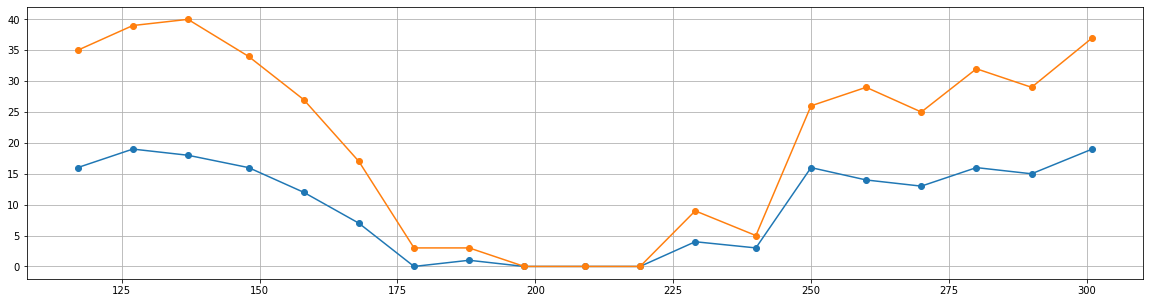

In [107]:
plt.figure(figsize=(20,5))
for i in range(2007,2020):
    if i != 2015:
        pass
    else:
        plt.plot(agro[(agro.ind == 57603) & (agro.datetime.dt.year == i)].datetime.dt.day_of_year, agro[(
            agro.ind == 57603) & (agro.datetime.dt.year == i)].val_1, 'o-', alpha=1)
        plt.plot(agro[(agro.ind == 57603) & (agro.datetime.dt.year == i)].datetime.dt.day_of_year, agro[(
            agro.ind == 57603) & (agro.datetime.dt.year == i)].val_2, 'o-', alpha=1)
plt.grid()
#plt.xticks(pd.date_range('2007-05-07', '2019-09-07', 12))
plt.plot()


In [74]:
(z0 - func(None, torch.cat((z0, v[:, 0]), dim=-1))).mean()


tensor(17.4233, grad_fn=<MeanBackward0>)

In [79]:
import pandas as pd

In [80]:
agro = pd.read_parquet('./data/new_agro.parquet')

In [32]:
class newODEF(nn.Module):

    def __init__(self, layers: list[int], func):

        super().__init__()

        net = [nn.Linear(10, layers[0]),
               func()]

        for i in range(1, len(layers)):
            net.append(nn.Linear(layers[i-1], layers[i]))
            net.append(func())

        net.append(nn.Linear(layers[i], 2))

        self.net = nn.Sequential(*net)

    def forward(self, t, x):
        return self.net(x)


In [63]:
func = ODEF([2, 2], nn.Tanh).apply(init_weights)

In [68]:
func.net[2].named_children()

StopIteration: 

In [64]:
func.net[2].weight/func.net[4].weight


tensor([[ -0.2719,   0.9321],
        [ -0.4860, -68.9571]], grad_fn=<DivBackward0>)

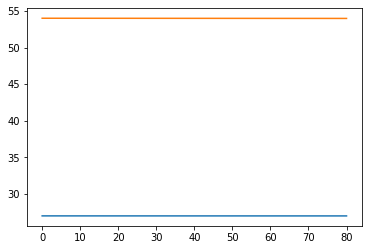

In [49]:
pred = odeint(func, z0, v, t, method='euler').detach().numpy()
plt.plot(np.arange(pred.shape[0]), pred[:, 0, 0])
plt.plot(np.arange(pred.shape[0]), pred[:, 0, 1])
plt.show()

In [177]:
y1, y2 = train_test_split(agro, test_size=0.1, shuffle=True)


In [178]:
from scipy.stats import ks_2samp

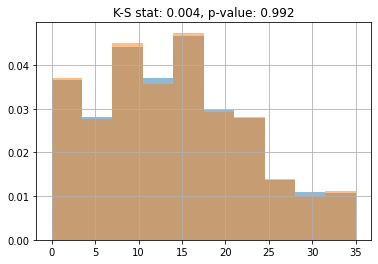

In [179]:
y1.val_1.hist(density=True, alpha=0.5)
y2.val_1.hist(density=True, alpha=0.5)
plt.title('K-S stat: %.3f, p-value: %.3f' % ks_2samp(y1.val_1, y2.val_1))
plt.show()


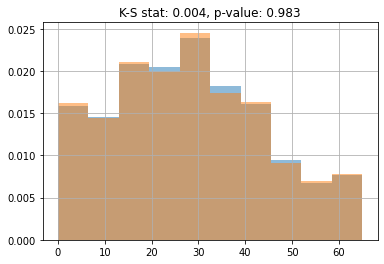

In [180]:
y1.val_2.hist(density=True, alpha=0.5)
y2.val_2.hist(density=True, alpha=0.5)
plt.title('K-S stat: %.3f, p-value: %.3f' % ks_2samp(y1.val_2, y2.val_2))
plt.show()


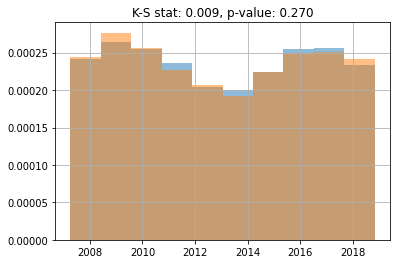

In [183]:
y1.datetime.hist(density=True, alpha=0.5)
y2.datetime.hist(density=True, alpha=0.5)
plt.title('K-S stat: %.3f, p-value: %.3f' % ks_2samp(y1.datetime, y2.datetime))
plt.show()


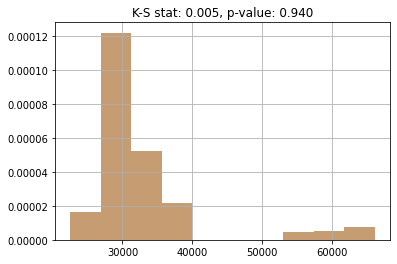

In [184]:
y1.ind.hist(density=True, alpha=0.5)
y2.ind.hist(density=True, alpha=0.5)
plt.title('K-S stat: %.3f, p-value: %.3f' % ks_2samp(y1.ind, y2.ind))
plt.show()


In [187]:
class DataNPZ(Dataset):

    def __init__(self, val: bool = False):

        self.paths = list(Path('data/dataset').glob('*.npz'))
        train_paths, val_paths = train_test_split(
            self.paths, test_size=0.1, shuffle=True)

        if val:
            self.paths = val_paths
        else:
            self.paths = train_paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):

        path = self.paths[index % self.__len__()]
        data = np.load(path)

        return data['feature'], data['target']


In [190]:
data = DataNPZ(val=True)

In [208]:
data = DataNPZ(val=True)
val1 = []
val2 = []
for i in range(len(data)):
    val1.append(data[i][1][0, 0])
    val2.append(data[i][1][0, 1])


data = DataNPZ(val=False)
tr1 = []
tr2 = []
for i in range(len(data)):
    tr1.append(data[i][1][0, 0])
    tr2.append(data[i][1][0, 1])


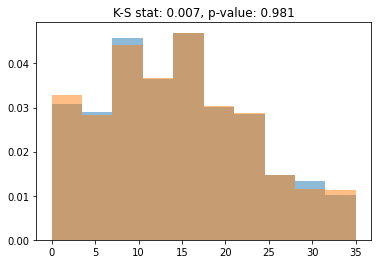

In [213]:
_, bins, _ = plt.hist(val1, density=True, alpha=0.5)
plt.hist(tr1, density=True, bins=bins, alpha=0.5)
plt.title('K-S stat: %.3f, p-value: %.3f' % ks_2samp(val1, tr1))
plt.show()


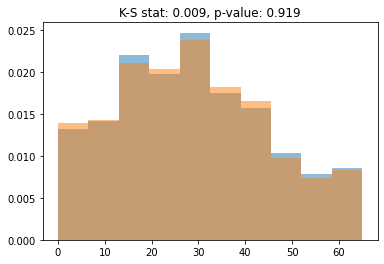

In [214]:
_, bins, _ = plt.hist(val2, density=True, alpha=0.5)
plt.hist(tr2, density=True, bins=bins, alpha=0.5)
plt.title('K-S stat: %.3f, p-value: %.3f' % ks_2samp(val2, tr2))
plt.show()
